## 1. Import libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## 2. Data

In [3]:
# create known parameters
weight1 = 0.5
weight2 = 0.1
bias   = 0.3

# create data
start = 0
end   = 1
step  = 0.02
X     = torch.arange(start, end, step).unsqueeze(1)
y     = weight1 * X * X + weight2 * X + bias

In [4]:
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3022],
         [0.3048],
         [0.3078],
         [0.3112],
         [0.3150],
         [0.3192],
         [0.3238],
         [0.3288],
         [0.3342]]))

In [5]:
train_split      = int(0.8 * len(X))
X_train, y_train = X [ :train_split], y[ :train_split]
X_test, y_test   = X [train_split: ], y[train_split: ]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## 3. Model

In [6]:
class LinearRegressionModel(nn.Module):

    def __init__ (self):
        super().__init__()
        self.weight1 = nn.Parameter(torch.randn(1, dtype = torch.float), requires_grad = True)
        self.weight2 = nn.Parameter(torch.randn(1, dtype = torch.float), requires_grad = True)
        self.bias    = nn.Parameter(torch.randn(1, dtype = torch.float), requires_grad = True)

    def forward (self, x: torch.Tensor):
        slope = self.weight1 * x * x + self.weight2 * x + self.bias
        return slope

In [7]:
torch.manual_seed(41)
model = LinearRegressionModel()
model.state_dict()

OrderedDict([('weight1', tensor([0.7906])),
             ('weight2', tensor([-0.6410])),
             ('bias', tensor([0.1660]))])

In [8]:
model.to(device)

LinearRegressionModel()

In [9]:
next(model.parameters()).device

device(type='cuda', index=0)

## 4. Training

In [10]:
loss_fn   = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [11]:
epochs = 1000 

# Put data on the available device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.3632608950138092 | Test loss: 0.5472081303596497
Epoch: 100 | Train loss: 0.02962702326476574 | Test loss: 0.03922642022371292
Epoch: 200 | Train loss: 0.02056671492755413 | Test loss: 0.0792621299624443
Epoch: 300 | Train loss: 0.019105849787592888 | Test loss: 0.08673802018165588
Epoch: 400 | Train loss: 0.01814126782119274 | Test loss: 0.08268474787473679
Epoch: 500 | Train loss: 0.017174985259771347 | Test loss: 0.07831365615129471
Epoch: 600 | Train loss: 0.016210339963436127 | Test loss: 0.07363712787628174
Epoch: 700 | Train loss: 0.015244080685079098 | Test loss: 0.06957770138978958
Epoch: 800 | Train loss: 0.014278664253652096 | Test loss: 0.06490115821361542
Epoch: 900 | Train loss: 0.013313177041709423 | Test loss: 0.06084173917770386


In [12]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weight1: {weight1}, weight2: {weight2}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weight1', tensor([0.8033], device='cuda:0')),
             ('weight2', tensor([-0.1534], device='cuda:0')),
             ('bias', tensor([0.3410], device='cuda:0'))])

And the original values for weights and bias are:
weight1: 0.5, weight2: 0.1, bias: 0.3


## Prediction

In [13]:
# Turn model into evaluation mode
model.eval()

# Make predictions on the test data
with torch.no_grad():
    y_preds = model(X_test)
    
y_preds

tensor([[0.7325],
        [0.7554],
        [0.7790],
        [0.8033],
        [0.8282],
        [0.8537],
        [0.8799],
        [0.9067],
        [0.9341],
        [0.9622]], device='cuda:0')

## Plot the predictions

In [16]:
def plot_predictions(train_data   = X_train.cpu(), 
                     train_labels = y_train.cpu(), 
                     test_data    = X_test.cpu(), 
                     test_labels  = y_test.cpu(), 
                     predictions  = None):

    plt.figure(figsize=(7,5))
    plt.scatter(train_data, train_labels, c = "b", s = 4, label = "Training data")
    plt.scatter(test_data, test_labels, c = "g", s = 4, label = "Testing data")

    if predictions is not None:
      # Plot the predictions in red (predictions were made on the test data)
      plt.scatter(test_data, predictions, c = "r", s = 4, label = "Predictions")
      
    plt.legend(prop={"size": 10})

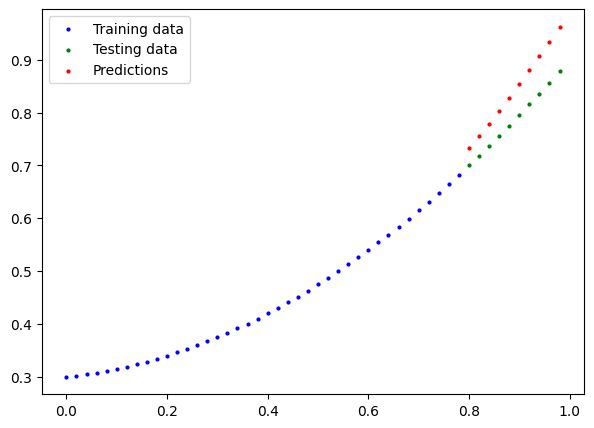

In [17]:
plot_predictions(predictions = y_preds.cpu())

## Save model

In [18]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "model1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/model1.pth


## Load model

In [19]:
# Instantiate a fresh instance of LinearRegressionModel
loaded_model = LinearRegressionModel()

# Load model state dict 
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model.to(device)

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loaded model:
LinearRegressionModel()
Model on device:
cuda:0
